In [1]:
%matplotlib inline
from PIL import Image
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import os
import shutil

import torchvision.transforms as transforms
import torch
from models.experimental import attempt_load
from utils.general import non_max_suppression
from utils.torch_utils import select_device
from utils.feature_extraction import preprocess_image, detect_objects_yolov7, visualize_detections,\
    inspect_model_layers, extract_penultimate_features, extract_features_with_detection, \
    get_central_bbox_features, debug_feature_extraction, extract_features_batch
from utils.bbox_feature_extraction import extract_bbox_features, extract_all_bbox_features,\
get_central_bbox_roi_features,extract_roi_features_batch


In [2]:
# Load YOLOv7 model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = attempt_load('yolov7.pt', map_location=device)  # Load weights
model.eval()  # Set to evaluation mode

/home/ehajizad/dev/yolov7/models/experimental.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(w, map_location=map_location)  # load


Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block


/home/ehajizad/dev/cl_venv/lib/python3.10/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Model(
  (model): Sequential(
    (0): Conv(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (act): SiLU(inplace=True)
    )
    (1): Conv(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act): SiLU(inplace=True)
    )
    (2): Conv(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (act): SiLU(inplace=True)
    )
    (3): Conv(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act): SiLU(inplace=True)
    )
    (4): Conv(
      (conv): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1))
      (act): SiLU(inplace=True)
    )
    (5): Conv(
      (conv): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1))
      (act): SiLU(inplace=True)
    )
    (6): Conv(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (act): SiLU(inplace=True)
    )
    (7): Conv(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), strid

In [ ]:
class_id = 1
class_names = ["Snowmobile", "Helicopter", "Airplane"]
class_labels = ["/m/01x3jk","/m/09ct_","/m/0cmf2"] 

# Paths to your files
annotations_csv_path = "/home/ehajizad/dev/OIDv4_ToolKit/OID/csv_folder/test-annotations-bbox.csv"
images_dir = "/home/ehajizad/dev/OIDv4_ToolKit/OID/Dataset/test/"+class_names[class_id]+"/*.jpg"

# Class label for Helicopter (replace with the actual OID label)
class_label = class_labels[class_id]
# Load the annotations CSV
annotations = pd.read_csv(annotations_csv_path)

# Filter for helicopter class
obj_annotations = annotations[annotations["LabelName"] == class_label]

# Count bounding boxes per image
bbox_count_per_image = obj_annotations["ImageID"].value_counts()

# Get ImageIDs with exactly one bounding box
single_bbox_image_ids = bbox_count_per_image[bbox_count_per_image == 1].index

print(f"Filtered {len(single_bbox_image_ids)} images with a single bounding box.")


In [ ]:
import os
import glob

# Path to downloaded images and the list of filtered ImageIDs
images_dir = np.array(glob.glob("/home/ehajizad/dev/OIDv4_ToolKit/OID/Dataset/test/"+class_names[class_id]+"/*.jpg"))
filtered_image_ids = set(single_bbox_image_ids)  # Replace with your list of ImageIDs

# Delete images not in the filtered list
for image_file in images_dir:
    # Extract image ID (filename without extension) from the file path
    
    image_id = os.path.splitext(os.path.basename(image_file))[0]
    if image_id not in filtered_image_ids:
        print(image_id)
        os.remove(image_file)

print("Filtered downloaded images. Only single-bbox images are retained.")


In [ ]:
import os
import glob

# Path to downloaded images and the list of filtered ImageIDs
class_id = 2
images_dir = np.array(glob.glob("/home/ehajizad/dev/OIDv4_ToolKit/OID/Dataset/test/"+class_names[class_id]+"/*.jpg"))

# Delete images not in the filtered list
for i, image_file in enumerate(images_dir):
    # Extract image ID (filename without extension) from the file path
    if i >350:
        os.remove(image_file)

print("Filtered downloaded images. Only single-bbox images are retained.")

Filtered downloaded images. Only single-bbox images are retained.


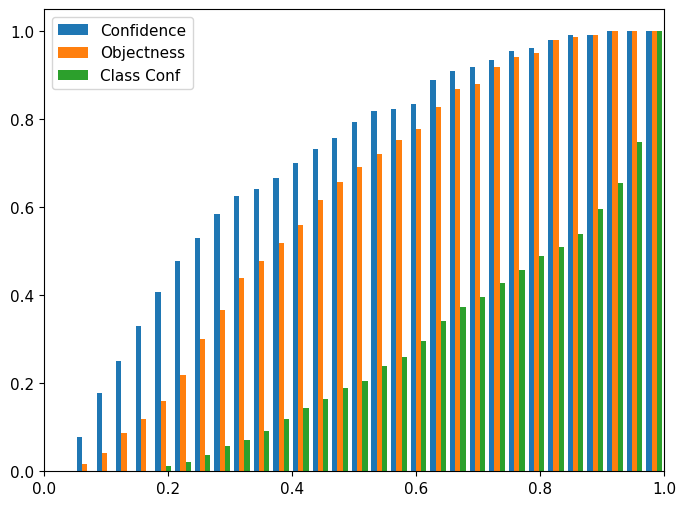

In [ ]:
import glob
class_names = ["Snowmobile", "Helicopter"]
class_id = 1
image_paths = np.array(glob.glob("/home/ehajizad/dev/OIDv4_ToolKit/OID/Dataset/test/"+class_names[class_id]+"/*.jpg"))
image_ids = np.array([0,4,5,7,9,10,11,13,14,15,17,18,19,20,
                      21,22,23,24,25,26,29,30,31,32,35,36,
                      37,38,39,41,43,45,46,47,48], dtype=int)

all_dets = []
for image_path in image_paths:
    # Preprocess the image
    image_tensor = preprocess_image(image_path, image_size=640)

    # Detect objects using YOLOv7
    detections = detect_objects_yolov7(model, image_tensor, conf_threshold=0.05)
    if len(detections):
        all_dets.append([detections[0][1], detections[0][3], detections[0][1]/detections[0][3]])
    
unknown_all_dets = np.array(all_dets).round(2)

# Create a histogram
bins = 30  # Number of bins

# Plot the cumulative histogram
plt.figure(figsize=(8, 6))
plt.hist(unknown_all_dets,30, cumulative=True, density=True)
plt.xlim([0,1])
plt.legend(["Confidence", "Objectness", "Class Conf"])
plt.show()

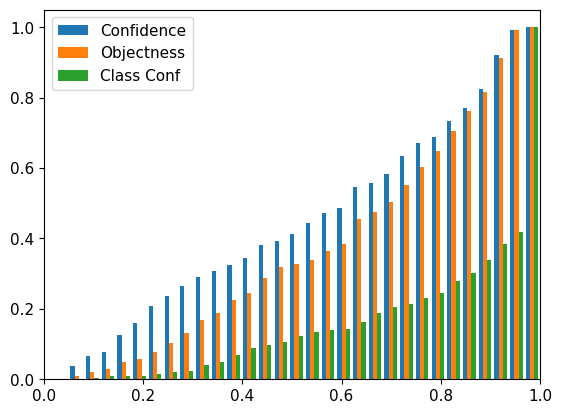

In [ ]:
import glob
class_names = ["Snowmobile", "Helicopter", "Airplane"]
class_id = 2
image_paths = np.array(glob.glob("/home/ehajizad/dev/OIDv4_ToolKit/OID/Dataset/test/"+class_names[class_id]+"/*.jpg"))

image_ids = np.array([3,7,9,11,12,13,14,15,16,22,23,27,28,31,33,34,36,37,39,44,47,48,49], dtype=int)


all_dets = []
for image_path in image_paths:
    # Preprocess the image
    image_tensor = preprocess_image(image_path, image_size=640)

    # Detect objects using YOLOv7
    detections = detect_objects_yolov7(model, image_tensor, conf_threshold=0.05)
    if len(detections):
        all_dets.append([detections[0][1], detections[0][3], detections[0][1]/detections[0][3]])

known_all_dets = np.array(all_dets).round(2)
plt.hist(known_all_dets,30, cumulative=True, density=True)
plt.xlim([0,1])
plt.legend(["Confidence", "Objectness", "Class Conf"])
plt.show()

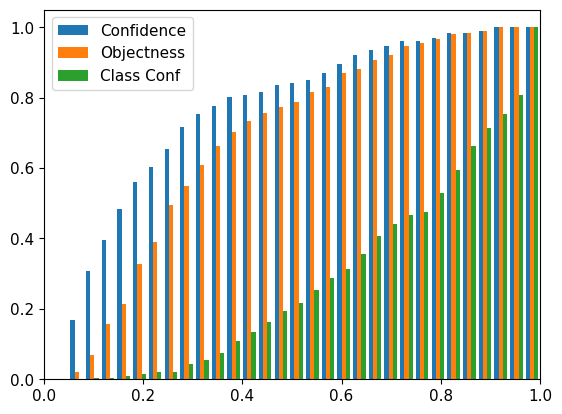

In [ ]:
import glob
class_names = ["Snowmobile", "Helicopter", "Airplane", "Starfish"]
class_id = 3
image_paths = np.array(glob.glob("/home/ehajizad/dev/OIDv4_ToolKit/OID/Dataset/train/"+class_names[class_id]+"/*.jpg"))

all_dets = []
for image_path in image_paths:
    # Preprocess the image
    image_tensor = preprocess_image(image_path, image_size=640)

    # Detect objects using YOLOv7
    detections = detect_objects_yolov7(model, image_tensor, conf_threshold=0.05)
    if len(detections):
        all_dets.append([detections[0][1], detections[0][3], detections[0][1]/detections[0][3]])

novel_all_dets = np.array(all_dets).round(2)
plt.hist(novel_all_dets,30,  cumulative=True, density=True)
plt.xlim([0,1])
plt.legend(["Confidence", "Objectness", "Class Conf"])
plt.show()

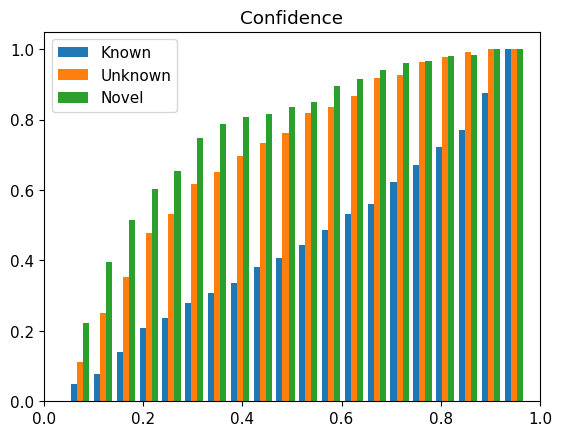

[[       0.05        0.08        0.14        0.21        0.24        0.28        0.31        0.34        0.38        0.41        0.44        0.49        0.53        0.56        0.62        0.67        0.72        0.77        0.88           1]
 [       0.11        0.25        0.35        0.48        0.53        0.62        0.65         0.7        0.73        0.76        0.82        0.84        0.87        0.92        0.93        0.96        0.98        0.99           1           1]
 [       0.22         0.4        0.51         0.6        0.65        0.75        0.79        0.81        0.82        0.84        0.85         0.9        0.92        0.94        0.96        0.97        0.98        0.99           1           1]]

 [       0.05         0.1        0.14        0.19        0.23        0.28        0.33        0.37        0.42        0.46        0.51        0.56         0.6        0.65        0.69        0.74        0.79        0.83        0.88        0.92        0.97]


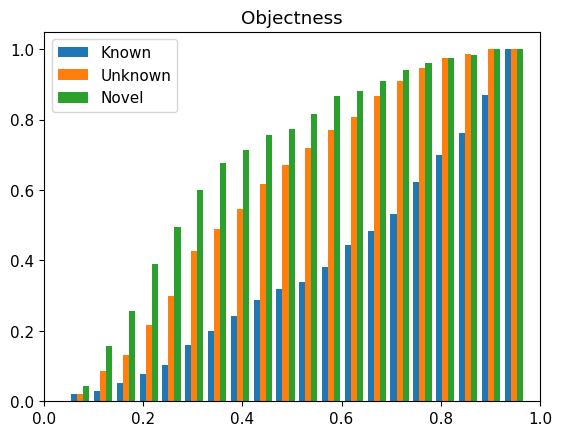

[[       0.02        0.03        0.05        0.08         0.1        0.16         0.2        0.24        0.29        0.32        0.34        0.38        0.44        0.48        0.53        0.62         0.7        0.76        0.87           1]
 [       0.02        0.09        0.13        0.22         0.3        0.43        0.49        0.55        0.62        0.67        0.72        0.77        0.81        0.87        0.91        0.95        0.98        0.99           1           1]
 [       0.04        0.16        0.26        0.39         0.5         0.6        0.68        0.71        0.76        0.77        0.82        0.87        0.88        0.91        0.94        0.96        0.98        0.99           1           1]]

 [       0.05         0.1        0.14        0.19        0.23        0.28        0.33        0.37        0.42        0.46        0.51        0.56         0.6        0.65        0.69        0.74        0.79        0.83        0.88        0.92        0.97]


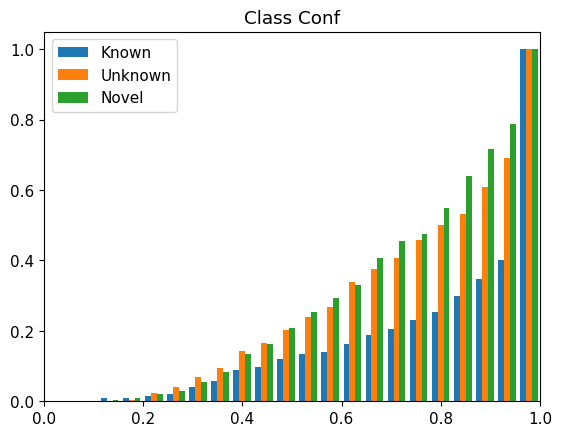

[[       0.01        0.01        0.02        0.02        0.04        0.06        0.09         0.1        0.12        0.14        0.14        0.16        0.19         0.2        0.23        0.25         0.3        0.35         0.4           1]
 [          0           0        0.02        0.04        0.07        0.09        0.14        0.16         0.2        0.24        0.27        0.34        0.37        0.41        0.46         0.5        0.53        0.61        0.69           1]
 [          0        0.01        0.02        0.03        0.05        0.08        0.13        0.16        0.21        0.25        0.29        0.33        0.41        0.46        0.48        0.55        0.64        0.72        0.79           1]]

 [       0.11        0.15         0.2        0.24        0.29        0.33        0.38        0.42        0.47        0.51        0.55         0.6        0.64        0.69        0.73        0.78        0.82        0.87        0.91        0.96           1]


In [ ]:
confs = ["Confidence", "Objectness", "Class Conf"]
for i in range(3):
    values, bin_edges, _ = plt.hist([known_all_dets[:,i] , unknown_all_dets[:,i], novel_all_dets[:,i]], 20, density=True, cumulative=True)
    plt.xlim([0,1])
    plt.legend(["Known", "Unknown", "Novel"])
    plt.title(confs[i])
    plt.show()
    print(values.round(2))
    print("\n",bin_edges.round(2))

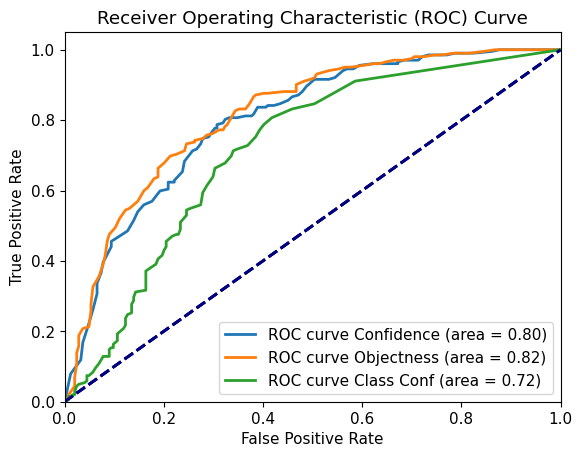

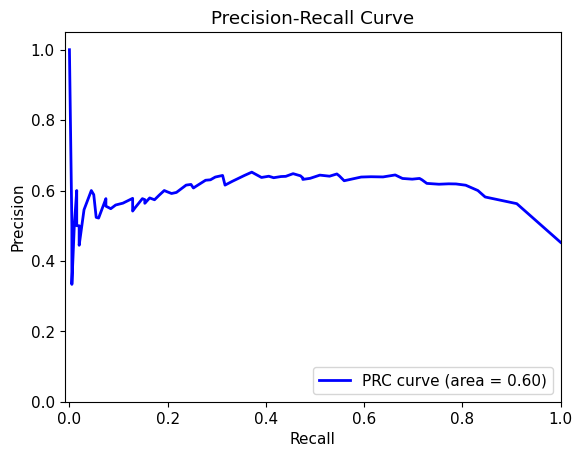

In [ ]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve

for i in range(3):
    confidence_positive = -novel_all_dets[:,i]  # Confidence scores for positive samples
    confidence_negative = -known_all_dets[:,i]  # Confidence scores for negative samples

    # Concatenate positive and negative confidence scores
    confidence_scores = np.concatenate([confidence_positive, confidence_negative])
    y_true_labels = np.concatenate([np.ones(len(confidence_positive)), np.zeros(len(confidence_negative))])

    # --- ROC Curve ---
    # Compute ROC curve and ROC AUC
    fpr, tpr, thresholds_roc = roc_curve(y_true_labels, confidence_scores)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.plot(fpr, tpr, lw=2, label=f'ROC curve {confs[i]} (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    # plt.show()

# --- Precision-Recall Curve ---
precision, recall, thresholds_pr = precision_recall_curve(y_true_labels, confidence_scores)
prc_auc = auc(recall, precision)
# Plot Precision-Recall curve
plt.figure()
plt.plot(recall, precision, color='b', lw=2, label=f'PRC curve (area = {prc_auc:.2f})')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
import glob

plt.close('all')
# Directory containing snowmobile images
class_names = ["Snowmobile", "Helicopter","Airplane", "Starfish"]
class_id = 3

class_names_yolo = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light',
         'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
         'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee',
         'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard',
         'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
         'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
         'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
         'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear',
         'hair drier', 'toothbrush' ]

image_paths = glob.glob("/home/ehajizad/dev/OIDv4_ToolKit/OID/Dataset/test/"+class_names[class_id]+"/*.jpg")
image_paths = glob.glob("/home/ehajizad/dev/OIDv4_ToolKit/OID/Dataset/train/"+class_names[class_id]+"/*.jpg")

for image_path in image_paths[10:20]:
    print(image_path)
    # Preprocess the image
    image_tensor = preprocess_image(image_path, image_size=640)

    # Detect objects using YOLOv7
    detections = detect_objects_yolov7(model, image_tensor, conf_threshold=0.05)

    # Visualize the detections inline
    visualize_detections(image_path, detections, class_names_yolo)